In [ ]:
#
# For licensing see accompanying LICENSE file.
# Copyright (C) 2025 Apple Inc. All Rights Reserved.
#

import jax
import jax.numpy as jnp
from bloop.optim import bloop_direction, init_bloop, pcgrad_direction, init_pcgrad, mixed_direction, dynamic_barrier_direction

In this example, we use gradient surgery methods to solve the multi-task problem with two tasks that are quadratic. The main task corresponds to an underparameterized quadratic:
$$
L_{main}(\theta) = \frac12 \|X\theta - y\|^2
$$
where $X\in\mathbb{R}^{n\times p}$ with $n=256$ and $p=300$.

In [2]:
def generate_problem(key, dim, conditioning):
    '''Generate the parameters of the problem.

    Gives the true parameters, the data covariance matrix, 
    and the target of the outer optimization problem.
    '''
    params_key, outer_key, new_key = jax.random.split(key, 3)
    true_params = jax.random.normal(params_key, shape=(dim,))
    eigenvalues = jnp.linspace(1, conditioning, dim)
    data_cov = jnp.diag(eigenvalues)
    outer_target = 10 * jax.random.normal(outer_key, shape=(dim,))
    return true_params, data_cov, outer_target, new_key


def get_data(key, true_params, batch_size, noise_level=0.01, data_cov=None):
    '''Generate a synthetic dataset for a linear regression problem.
    '''
    p = true_params.shape[0]
    if data_cov is None:
        data_cov = jnp.eye(p)
    data_key, noise_key, new_key = jax.random.split(key, 3)
    X = jax.random.normal(data_key, shape=(batch_size, p)) @ data_cov
    y = X @ true_params + noise_level * jax.random.normal(noise_key, shape=(batch_size,))
    return X, y, new_key


def main_loss_fn(params, X, y):
    '''quadratic loss'''
    return 0.5 * jnp.mean((jnp.dot(X, params) - y) ** 2)


key = jax.random.PRNGKey(0)
p = 300
n = 256
conditioning = 10.0
noise_level = 0.05

true_params, data_cov, outer_target, key = generate_problem(
    key, dim=p, conditioning=conditioning
)

X, y, key = get_data(key, true_params, n, noise_level=noise_level, data_cov=data_cov)


The auxiliary task corresponds to another quadratic, which is strongly convex:

$$
L_{aux} (\theta) = \frac12\|\theta - \theta^*\|^2
$$

where $\theta^*$ is a random vector. 

In [3]:
def aux_loss_fn(params, target):
    return 0.5 * jnp.linalg.norm(params - target) ** 2

The goal is to find parameters $\theta$ such that both losses are low. 
We assume that we only have access to mini-batch gradients from the main loss, obtained by sub-sampling data from $X, y$.

We compare different baselines, which all have a hyper-parameter $\lambda$ that trades-off between $L_{main}$ and $L_{aux}$.
- The mixed optimization method, that minimizes $L_{main} + \lambda L_{aux}$ using SGD
- PCGrad, that computes the (stochastic) gradients from both losses, and orthogonalizes them if they do not point in the same direction
- Dynamic barrier direction, which goes in the direction $d = \mu g_{main} + \lambda g_{aux}$ with $\mu = \max(1 - \lambda \frac{g_{aux}\cdot g_{main}}{\|g_{main}\|^2}, 0)$
- Our proposed method, Bloop, which goes in the direction $d= g_{main} + \lambda (g_{aux} - \frac{g_{aux}\cdot g^{ema}_{main}}{\|g^{ema}_{main}\|^2}g_{main}^{ema})$. The main difference with the previous methods is the EMA: in the right hand term, $g^{ema}_{main}$ is an EMA of the past gradients from the main loss.

For all methods, the `train_step` works in a similar fashion:
- We gather a stochastic gradient from both the main and the auxiliary loss
- We merge the two gradients into one using the method
- We update the parameters following this new direction

In [4]:
def get_mini_batch_iterator(key, X, y, batch_size):
    n = X.shape[0]
    perm_key, new_key = jax.random.split(key, 2)
    perm = jax.random.permutation(perm_key, n)

    def get_batch_fn(i):
        idxs = perm[i * batch_size : (i + 1) * batch_size]
        return X[idxs], y[idxs]

    return get_batch_fn, new_key


main_value_and_grad = jax.value_and_grad(main_loss_fn)

aux_value_and_grad = jax.value_and_grad(aux_loss_fn)


def train_loop(
    key,
    X,
    y,
    batch_size,
    eval_every,
    params,
    outer_target,
    method_state,
    learning_rate,
    method,
):
    n, _ = X.shape
    get_batch_fn, key = get_mini_batch_iterator(key, X, y, batch_size)
    n_iters = n // batch_size
    aux_losses = []
    main_losses = []
    direction_fn = {
        "mixed": mixed_direction,
        "bloop": bloop_direction,
        "pcgrad": pcgrad_direction,
        "dynamic_barrier": dynamic_barrier_direction,
    }[method]

    def train_step(i, params, method_state):
        X_batch, y_batch = get_batch_fn(i)  # get the next mini-batch
        _, main_gradient = main_value_and_grad(params, X_batch, y_batch)  # compute the gradient for the main loss
        _, aux_gradient = aux_value_and_grad(params, outer_target)  # compute the gradient for the auxiliary loss
        direction, method_state = direction_fn(
            main_gradient, aux_gradient, method_state
        )  # merge the gradients
        params = params - learning_rate * direction  # update the parameters
        return params, method_state
    
    def test_step(params, X, y, outer_target):
        aux_loss = aux_loss_fn(params, outer_target)
        main_loss = main_loss_fn(params, X, y)
        return aux_loss, main_loss

    for i in range(n_iters):
        if i % eval_every == 0:
            aux_loss, main_loss  = test_step(
                params, X, y, outer_target
            )
            aux_losses.append(aux_loss)
            main_losses.append(main_loss)
        params, method_state = train_step(i, params, method_state)
    return params, method_state, aux_loss, main_losses, key


train_loop = jax.jit(train_loop, static_argnames=["batch_size", "eval_every", "method"])

First, let's compare the methods with a fixed value of $\lambda$. We use an ema factor of $0.01$ for Bloop.

Training with lbda=1, method=bloop
Training with lbda=1, method=regul
Training with lbda=1, method=pcgrad
Training with lbda=1, method=dynamic_barrier


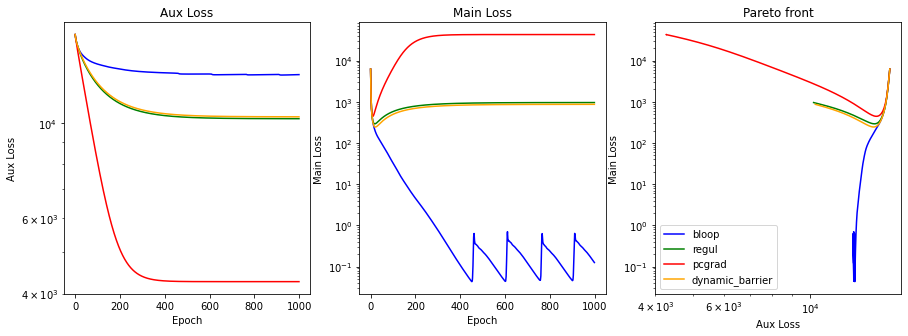

In [5]:
import matplotlib.pyplot as plt

batch_size = 64
n_epochs = 1000
learning_rate = 1e-3
eval_every = 10000

lbda = 1
params_list = [
    (1e-2, "bloop", init_bloop, "blue"),
    (1.0, "mixed", init_bloop, "green"),  
    (1.0, "pcgrad", init_pcgrad, "red"),
    (1.0, "dynamic_barrier", init_bloop, "orange"),
]


def get_results(key, ema, method, init_method, lbda):
    params = jnp.zeros(p)
    method_state = init_method(key, params, ema=ema, lbda=lbda, init="zeros")
    aux_losses_list = []
    main_losses_list = []
    for epoch in range(n_epochs):
        (
            params,
            method_state,
            aux_losses,
            main_losses,
            _,
        ) = train_loop(
            key,
            X,
            y,
            batch_size,
            eval_every,
            params,
            outer_target,
            method_state,
            learning_rate,
            method,
        )
        aux_losses_list.append(aux_losses)
        main_losses_list.append(main_losses)
    aux_losses_list = jnp.array(aux_losses_list).flatten()
    main_losses_list = jnp.array(main_losses_list).flatten()
    return aux_losses_list, main_losses_list

f, axes = plt.subplots(1, 3, figsize=(15, 5))
for ema, method, init_method, color in params_list:
    print(f"Training with lbda={lbda}, method={method}")
    aux_losses_list, main_losses_list = get_results(key, ema, method, init_method, lbda)
    for i, to_plot in enumerate([aux_losses_list, main_losses_list]):
        axes[i].plot(to_plot, color=color)
    axes[2].plot(aux_losses_list, main_losses_list, color=color, label=method)
for ax in axes:
    ax.set_yscale("log")
axes[2].set_xscale("log")
axes[0].set_title("Aux Loss")
axes[1].set_title("Main Loss")
axes[2].set_title("Pareto front")
for i in [0, 1]:
    axes[i].set_xlabel("Epoch")
axes[0].set_ylabel("Aux Loss")
axes[1].set_ylabel("Main Loss")
axes[2].set_xlabel("Aux Loss")
axes[2].set_ylabel("Main Loss")
axes[2].legend()



Here, the first two figures display the evolution of the auxiliary and main loss, respectively. The final figure displays the *Pareto front*, that is the main loss as a function of the auxiliary loss. We see that Bloop has a very different behavior from the other methods: it manages to decrease far more the main loss, at the expense of the auxiliary loss. As a consequence, it's Pareto front looks very different.

Finally, we can investigate the impact of $\lambda$, by displaying, for each $\lambda$ in a grid, the point with the best main loss:

Training with method=bloop
Training with method=regul
Training with method=pcgrad
Training with method=dynamic_barrier


Text(0, 0.5, 'Main Loss')

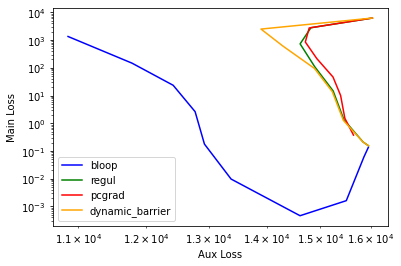

In [6]:
for ema, method, init_method, color in params_list:
    to_plot = []
    print(f"Training with method={method}")
    for lbda in jnp.logspace(-3, 3, 10):
        
        aux_losses_list, main_losses_list = get_results(key, ema, method, init_method, lbda)
        best_point = jnp.argmin(main_losses_list)
        to_plot.append((aux_losses_list[best_point], main_losses_list[best_point]))
    plt.plot(*zip(*to_plot), color=color, label=method)

plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Aux Loss")
plt.ylabel("Main Loss")

We observe that Bloop reaches far more interesting points, with both lower auxiliary and main losses.